In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import scipy 
from sklearn.metrics import classification_report, accuracy_score
#Importing Libraries for Outlier Detection
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, to_graphviz
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, average_precision_score, f1_score, roc_curve, auc
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb 

In [2]:
df = pd.read_csv('Fin_Data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


From the EDA, I learned the account that received funds during a transfer was not used at all for cashing out for the fraudulent transactions. It doesn't seem nameDest and NameOrig has any fraudulent transactions. Therefore, I will drop these two columns.

In [5]:
#remove nameDest and NameOrig
dataset = df.copy() # making a copy
temp = ["nameOrig","nameDest"]
df = df.drop(temp, 1)

C:\Users\seren\AppData\Local\Temp\ipykernel_19052\2265210104.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(temp, 1)


In [6]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


<br> from the EDA, I learned the fraud only happends in "Transfer" and "Cash_out", so I will only include these two for further analysis </br>


In [7]:
df_new = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
#df_new = df[df["type"] == 'CASH_OUT' | df[df["type"] == 'TRANSFER']]
df_new

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,15325.00,0.0,5083.00,51513.44,0,0
19,1,TRANSFER,215310.30,705.00,0.0,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,10835.00,0.0,6267.00,2719172.89,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,0


In [8]:
df_new = pd.get_dummies(df_new,columns=['type'])

In [9]:
df_new.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,0,1


In [10]:
#adding the hour feature
df_new["HourOfDay"] = np.nan # initializing feature column
df_new.HourOfDay = df_new.step % 24

In [11]:
df_new.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,HourOfDay
2,1,181.00,181.0,0.0,0.0,0.00,1,0,0,1,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0,1,0,1
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,0,1
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,0,1,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,0,1,1


In [12]:

#RandomState = 42 # does it matter what number it is?
#seed(21)
X = df_new.drop("isFraud",1)
y = df_new.isFraud

C:\Users\seren\AppData\Local\Temp\ipykernel_19052\3713161307.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_new.drop("isFraud",1)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False)

In [14]:
from sklearn.tree import DecisionTreeClassifier # Decision tree algorithm
from sklearn.ensemble import RandomForestClassifier # Random forest tree algorithm
from xgboost import XGBClassifier # XGBoost algorithm
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, precision_score
from sklearn .metrics import roc_auc_score

In [15]:
from sklearn import preprocessing
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.995
Random Forest: f1-score=0.995


In [17]:
print("Confusion matrix  ", (cm))
print ("AUC&ROC:", roc_auc_score(y_test, y_pred))

Confusion matrix   [[823058   3485]
 [   775   3805]]
AUC&ROC: 0.9132848348205407


In [18]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(X_train_scaled, y_train)
# Print the accuracy from the testing data.
print("accuracy score: ", accuracy_score(clf.predict(X_test_scaled), y_test))
#print("accuracy score: ", accuracy_score(y_test, clf.predict(X_test_scaled)))
print("F1 score: ", f1_score(clf.predict(X_test_scaled), y_test))
print("Confusion matrix  ", confusion_matrix(clf.predict(X_test_scaled), y_test))
print ("AUC&ROC:", roc_auc_score(clf.predict(X_test_scaled), y_test))

accuracy score:  0.9969126110094414
F1 score:  0.6144831730769231
Confusion matrix   [[826512   2535]
 [    31   2045]]
AUC&ROC: 0.9910048548256162


In [19]:
model = XGBClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("accuracy score: ", accuracy_score(y_pred, y_test))
print("F1 score: ", f1_score(y_pred, y_test))
print("Confusion matrix  ", confusion_matrix(y_pred, y_test))
print ("AUC&ROC:", roc_auc_score(y_pred, y_test))

accuracy score:  0.9990157894800168
F1 score:  0.9039229504345783
Confusion matrix   [[826457    732]
 [    86   3848]]
AUC&ROC: 0.9886271868484994


In [20]:
def model_result(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print("AUC&ROC score :", roc_auc_score(y_test, y_pred))
    print('F1 - score :',(f1_score(y_test,y_pred)))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test,y_pred))
    print("accuracy_score")
    print(accuracy_score(y_test,y_pred))
    print("classification_report")
    print(classification_report(y_test,y_pred))

In [21]:
#try SMOTE
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=0)
X, y = smt.fit_resample(X, y)



In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [23]:
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(X_train, y_train)
clf.predict(X_test)


array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [24]:
print("Logistic Regression ", model_result(clf, X_test, y_test))

AUPRC : 0.9775936447945001
AUC&ROC score : 0.9293116661095142
F1 - score : 0.9322246761304183
Confusion_matrix : 
[[734837  93261]
 [ 23845 805375]]
accuracy_score
0.9293400542321992
classification_report
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    828098
           1       0.90      0.97      0.93    829220

    accuracy                           0.93   1657318
   macro avg       0.93      0.93      0.93   1657318
weighted avg       0.93      0.93      0.93   1657318

Logistic Regression  None


In [25]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("XGB classifier: ", model_result(clf, X_test, y_test))

AUPRC : 0.999978051682905
AUC&ROC score : 0.9984311375243127
F1 - score : 0.9984344024254412
Confusion_matrix : 
[[825984   2114]
 [   485 828735]]
accuracy_score
0.9984318036731635
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828098
           1       1.00      1.00      1.00    829220

    accuracy                           1.00   1657318
   macro avg       1.00      1.00      1.00   1657318
weighted avg       1.00      1.00      1.00   1657318

XGB classifier:  None


In [26]:
clf = RandomForestClassifier(n_estimators=200, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
print("Random Forest: ", model_result(clf, X_test, y_test))

AUPRC : 0.9999958470917315
AUC&ROC score : 0.9993226117594416
F1 - score : 0.9993238503648316
Confusion_matrix : 
[[827059   1039]
 [    83 829137]]
accuracy_score
0.999323002586106
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828098
           1       1.00      1.00      1.00    829220

    accuracy                           1.00   1657318
   macro avg       1.00      1.00      1.00   1657318
weighted avg       1.00      1.00      1.00   1657318

Random Forest:  None


Based on the result, I will choose Random Forest.

In [27]:
#feature importance
feature_importance = dict(zip(df_new.columns, list(clf.feature_importances_)))
feature_importance

{'step': 0.0713586726986192,
 'amount': 0.13246469159945456,
 'oldbalanceOrg': 0.3607264879936395,
 'newbalanceOrig': 0.05874469656506708,
 'oldbalanceDest': 0.07880514870656236,
 'newbalanceDest': 0.16474299731828781,
 'isFraud': 9.63611687216666e-06,
 'isFlaggedFraud': 0.02576408338038537,
 'type_CASH_OUT': 0.021031192938292295,
 'type_TRANSFER': 0.08635239268281975}

<AxesSubplot:title={'center':'Feature Importance (RandomForest)'}, ylabel='Relative Importance'>

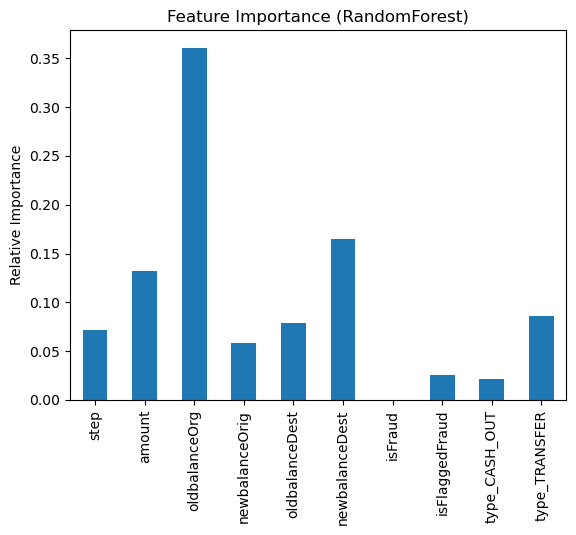

In [28]:
feature_df = pd.DataFrame(feature_importance, index=[0])
feature_df.T.plot.bar(title="Feature Importance (RandomForest)", ylabel='Relative Importance', legend=False)